In [1]:
%matplotlib inline

/home/ydeng/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '



Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

[u'data/names/English.txt', u'data/names/Czech.txt', u'data/names/Portuguese.txt', u'data/names/Vietnamese.txt', u'data/names/Arabic.txt', u'data/names/Polish.txt', u'data/names/Italian.txt', u'data/names/Spanish.txt', u'data/names/Chinese.txt', u'data/names/Irish.txt', u'data/names/Greek.txt', u'data/names/Scottish.txt', u'data/names/Dutch.txt', u'data/names/Japanese.txt', u'data/names/French.txt', u'data/names/Korean.txt', u'data/names/German.txt', u'data/names/Russian.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [3]:
print(category_lines['Italian'][:5])

[u'Abandonato', u'Abatangelo', u'Abatantuono', u'Abate', u'Abategiovanni']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]

torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt: 





In [5]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

n_hidden = 128

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).

Remember that PyTorch modules operate on Variables rather than straight
up Tensors.




In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.softmax = nn.LogSoftmax()
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (Variable(torch.FloatTensor(1, 1, self.hidden_size)),
                Variable(torch.FloatTensor(1, 1, self.hidden_size)))
    
    def forward(self, inputs):
        lstm_out, self.hidden = self.lstm(inputs, self.hidden)
        output = self.linear(lstm_out[-1])
        return self.softmax(output)
#         output = linear(lstm_out.view(1, -1))
#         return self.softmax(Variable(torch.Tensor(self.hidden)))

lstm = LSTM(n_letters, n_hidden, n_categories )

In [7]:
# input = Variable(letterToTensor('A'))
# hidden = Variable(torch.zeros(1, n_hidden))

# output, next_hidden = rnn(input, hidden)
# print(output)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [8]:
input = Variable(lineToTensor('Chen'))
# pack_sequence = nn.utils.rnn.pack_padded_sequence(input, [4])
# packed_input = pack_sequence(input)
# print(pack_sequence)
output = lstm(input)
print(output)

Variable containing:

Columns 0 to 9 
-2.7064 -3.0390 -2.7289 -2.8371 -2.9334 -2.9366 -2.8857 -2.8630 -2.9113 -2.8114

Columns 10 to 17 
-2.9594 -2.7704 -2.9235 -3.0319 -2.8571 -3.0999 -2.8123 -3.0213
[torch.FloatTensor of size 1x18]



In [9]:
output, output_len = nn.utils.rnn.pad_packed_sequence(output)
print(output)

Variable containing:
( 0 ,.,.) = 

Columns 0 to 8 
 1.00000e-02 *
  -0.2364  3.1672  1.8837 -5.0509  1.1784  3.2307 -2.2226 -1.8488  0.0970

Columns 9 to 17 
 1.00000e-02 *
  -0.2394  1.5211  2.3932 -4.8563  2.9453  2.4690 -2.2019  0.6301  2.3712

Columns 18 to 26 
 1.00000e-02 *
   0.9259  3.8919  1.7525 -2.8542  0.2249 -0.1405 -0.8375 -2.9339  3.2413

Columns 27 to 35 
 1.00000e-02 *
  -0.8228  1.2503 -4.9198 -2.1834 -1.1868 -1.7781  0.4952  0.8411  0.4956

Columns 36 to 44 
 1.00000e-02 *
  -2.2956 -0.4025  3.9140  1.7701 -1.4401 -1.7631  1.8511 -1.7274  3.9094

Columns 45 to 53 
 1.00000e-02 *
   2.1551 -2.1038  1.1695  1.3885  1.4687 -0.8448  2.3269  3.6272 -1.3037

Columns 54 to 62 
 1.00000e-02 *
  -0.6934 -3.4485  0.8047  0.5939 -0.5855 -0.2855  2.4420  1.0180  3.8085

Columns 63 to 71 
 1.00000e-02 *
  -0.6329  2.9163  0.3992  0.8820  0.5408 -0.3244 -0.9867  3.6900  0.5092

Columns 72 to 80 
 1.00000e-02 *
  -3.2178  0.9577  0.4044 -0.4840  0.2281 -2.9141 -4.6090  4.3417 -2.06

In [9]:
input = Variable(lineToTensor(''))
target = Variable(torch.LongTensor([15]))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(lstm.parameters(), lr = 0.005)
def train(inputs, target):
    lstm.zero_grad()
    lstm.hidden = lstm.init_hidden()
    output = lstm(input)

    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    return output, loss.data[0]

In [10]:
train(input, target)

(Variable containing:
 
 Columns 0 to 9 
 -2.8531 -2.8598 -2.8296 -2.7554 -2.8952 -3.0339 -2.7707 -2.9265 -3.0173 -2.8457
 
 Columns 10 to 17 
 -2.9487 -2.7476 -2.8232 -2.9658 -2.8602 -3.0542 -2.9058 -3.0108
 [torch.FloatTensor of size 1x18], 3.0542454719543457)

In [19]:
# input = Variable(lineToTensor('Albert'))
# hidden = Variable(torch.zeros(1, n_hidden))

# output, next_hidden = rnn(input[0], hidden)
# print(output)

As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

(u'Italian', 0)


We will also want a quick way to get a training example (a name and its
language):




In [12]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = Polish / line = Janowski
category = Scottish / line = Mcdonald
category = Scottish / line = Henderson
category = French / line = Giroux
category = German / line = Wehner
category = Korean / line = Yeon
category = Korean / line = Chang
category = German / line = Gottlieb
category = Dutch / line = Reynders
category = Spanish / line = Ramirez


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [13]:
loss_function = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [14]:
# learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = optim.SGD(lstm.parameters(), lr = 0.005)

def train(inputs, target):
    lstm.zero_grad()
    lstm.hidden = lstm.init_hidden()
    output = lstm(input)

    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    return output, loss.data[0]

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [15]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(line_tensor, category_tensor)
#     print(loss)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 12s) 2.8854 Rendon / Portuguese ✗ (Spanish)
10000 10% (0m 23s) 2.7848 Teague / Irish ✓
15000 15% (0m 35s) 3.0093 Simoes / Scottish ✗ (Portuguese)
20000 20% (0m 47s) 2.9166 Gandham / Scottish ✗ (English)
25000 25% (0m 59s) 2.9609 Tuma / Scottish ✗ (Arabic)
30000 30% (1m 10s) 2.8802 Gordon / Polish ✗ (Scottish)
35000 35% (1m 22s) 2.9558 Bando / Polish ✗ (Japanese)
40000 40% (1m 35s) 3.1624 Seok / Irish ✗ (Korean)
45000 45% (1m 46s) 2.9000 Harness / Greek ✗ (English)
50000 50% (1m 58s) 2.8261 Maslanka / Italian ✗ (Polish)
55000 55% (2m 9s) 3.0030 Slaski / Chinese ✗ (Polish)
60000 60% (2m 22s) 2.6441 Cui / Chinese ✓
65000 65% (2m 34s) 2.9815 Rodrigues / Chinese ✗ (Portuguese)
70000 70% (2m 45s) 2.9110 Zhan / English ✗ (Chinese)
75000 75% (2m 57s) 3.0361 Kaza / Chinese ✗ (Japanese)
80000 80% (3m 8s) 2.8411 Froy / Irish ✗ (English)
85000 85% (3m 20s) 2.7488 Faucher / French ✓
90000 90% (3m 32s) 2.6852 Piontek / Polish ✓
95000 95% (3m 43s) 2.9597 Svejda / Chinese ✗ (Czech)
100000 

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




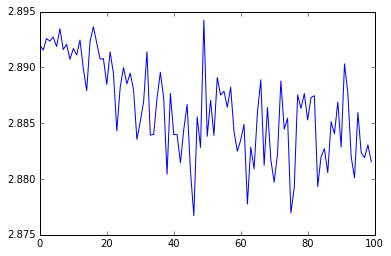

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




In [21]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
#     hidden = lstm.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i])
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

RuntimeError: matrices expected, got 1D, 2D tensors at /b/wheel/pytorch-src/torch/lib/TH/generic/THTensorMath.c:1232

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [20]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Hazaki')


> Dovesky


TypeError: forward() takes exactly 2 arguments (3 given)

The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




Exercises
=========

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


